# Linear regression with multiple inputs

In [20]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la

la.logger.setLevel("INFO")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generative model

In [21]:
n_cells = 300
cells = la.Dim(pd.Series([str(i) for i in range(n_cells)]), id="cell")

x1 = la.Fixed(
    pd.Series(np.random.uniform(0, 3, n_cells), index=cells.index),
    label="x1",
    symbol="x1",
)
x2 = la.Fixed(
    pd.Series(np.random.uniform(0, 3, n_cells), index=cells.index),
    label="x2",
    symbol="x2",
)

In [22]:
n_genes = 100
genes = la.Dim(pd.Series([str(i) for i in range(n_genes)]), id="gene")


def random_coefficient(n_genes):
    return (
        np.random.choice([-1, 1], n_genes)
        * np.random.normal(3.0, 1.0, n_genes)
        * (np.random.random(n_genes) > 0.5)
    )


slope_x1 = la.Fixed(
    pd.Series(random_coefficient(n_genes), index=genes.index), label="slope_x1"
)
slope_x2 = la.Fixed(
    pd.Series(random_coefficient(n_genes), index=genes.index), label="slope_x2"
)
slope_x12 = la.Fixed(
    pd.Series(random_coefficient(n_genes), index=genes.index), label="slope_x12"
)
intercept = la.Fixed(
    pd.Series(random_coefficient(n_genes), index=genes.index), label="intercept"
)
scale = la.Fixed(
    pd.Series(np.random.uniform(1.0, 1.2, n_genes), index=genes.index), label="scale"
)

gene_info = pd.DataFrame(
    {
        "slope_x1": slope_x1.prior_pd(),
        "slope_x2": slope_x2.prior_pd(),
        "slope_x12": slope_x12.prior_pd(),
        "intercept": intercept.prior_pd(),
    }
)

In [23]:
z = la.modular.Additive(definition=la.Definition([cells, genes]))

assert all(not la.variables.is_dim_broadcasted(dim) for dim in z)

z.intercept = intercept

assert not la.variables.is_dim_broadcasted(z[0])
assert la.variables.is_dim_broadcasted(z[1])

z.x1 = la.links.scalar.Linear(x=x1, a=slope_x1)
z.x2 = la.links.scalar.Linear(x=x2, a=slope_x2)
z.x12 = la.links.scalars.Linear([x1, x2], a=slope_x12)

assert all(la.variables.is_dim_broadcasted(dim) for dim in z)

alternative

In [24]:
z = la.modular.Additive(
    intercept=intercept,
    x1_effect=la.links.scalar.Linear(x=x1, a=slope_x1),
    x2_effect=la.links.scalar.Linear(x=x2, a=slope_x2),
    x12_effect=la.links.scalars.Linear([x1, x2], a=slope_x12),
    definition=la.Definition([cells, genes]),
)

assert all(la.variables.is_dim_broadcasted(dim) for dim in z)

In [25]:
dist = la.distributions.Normal(loc=z, scale=scale)


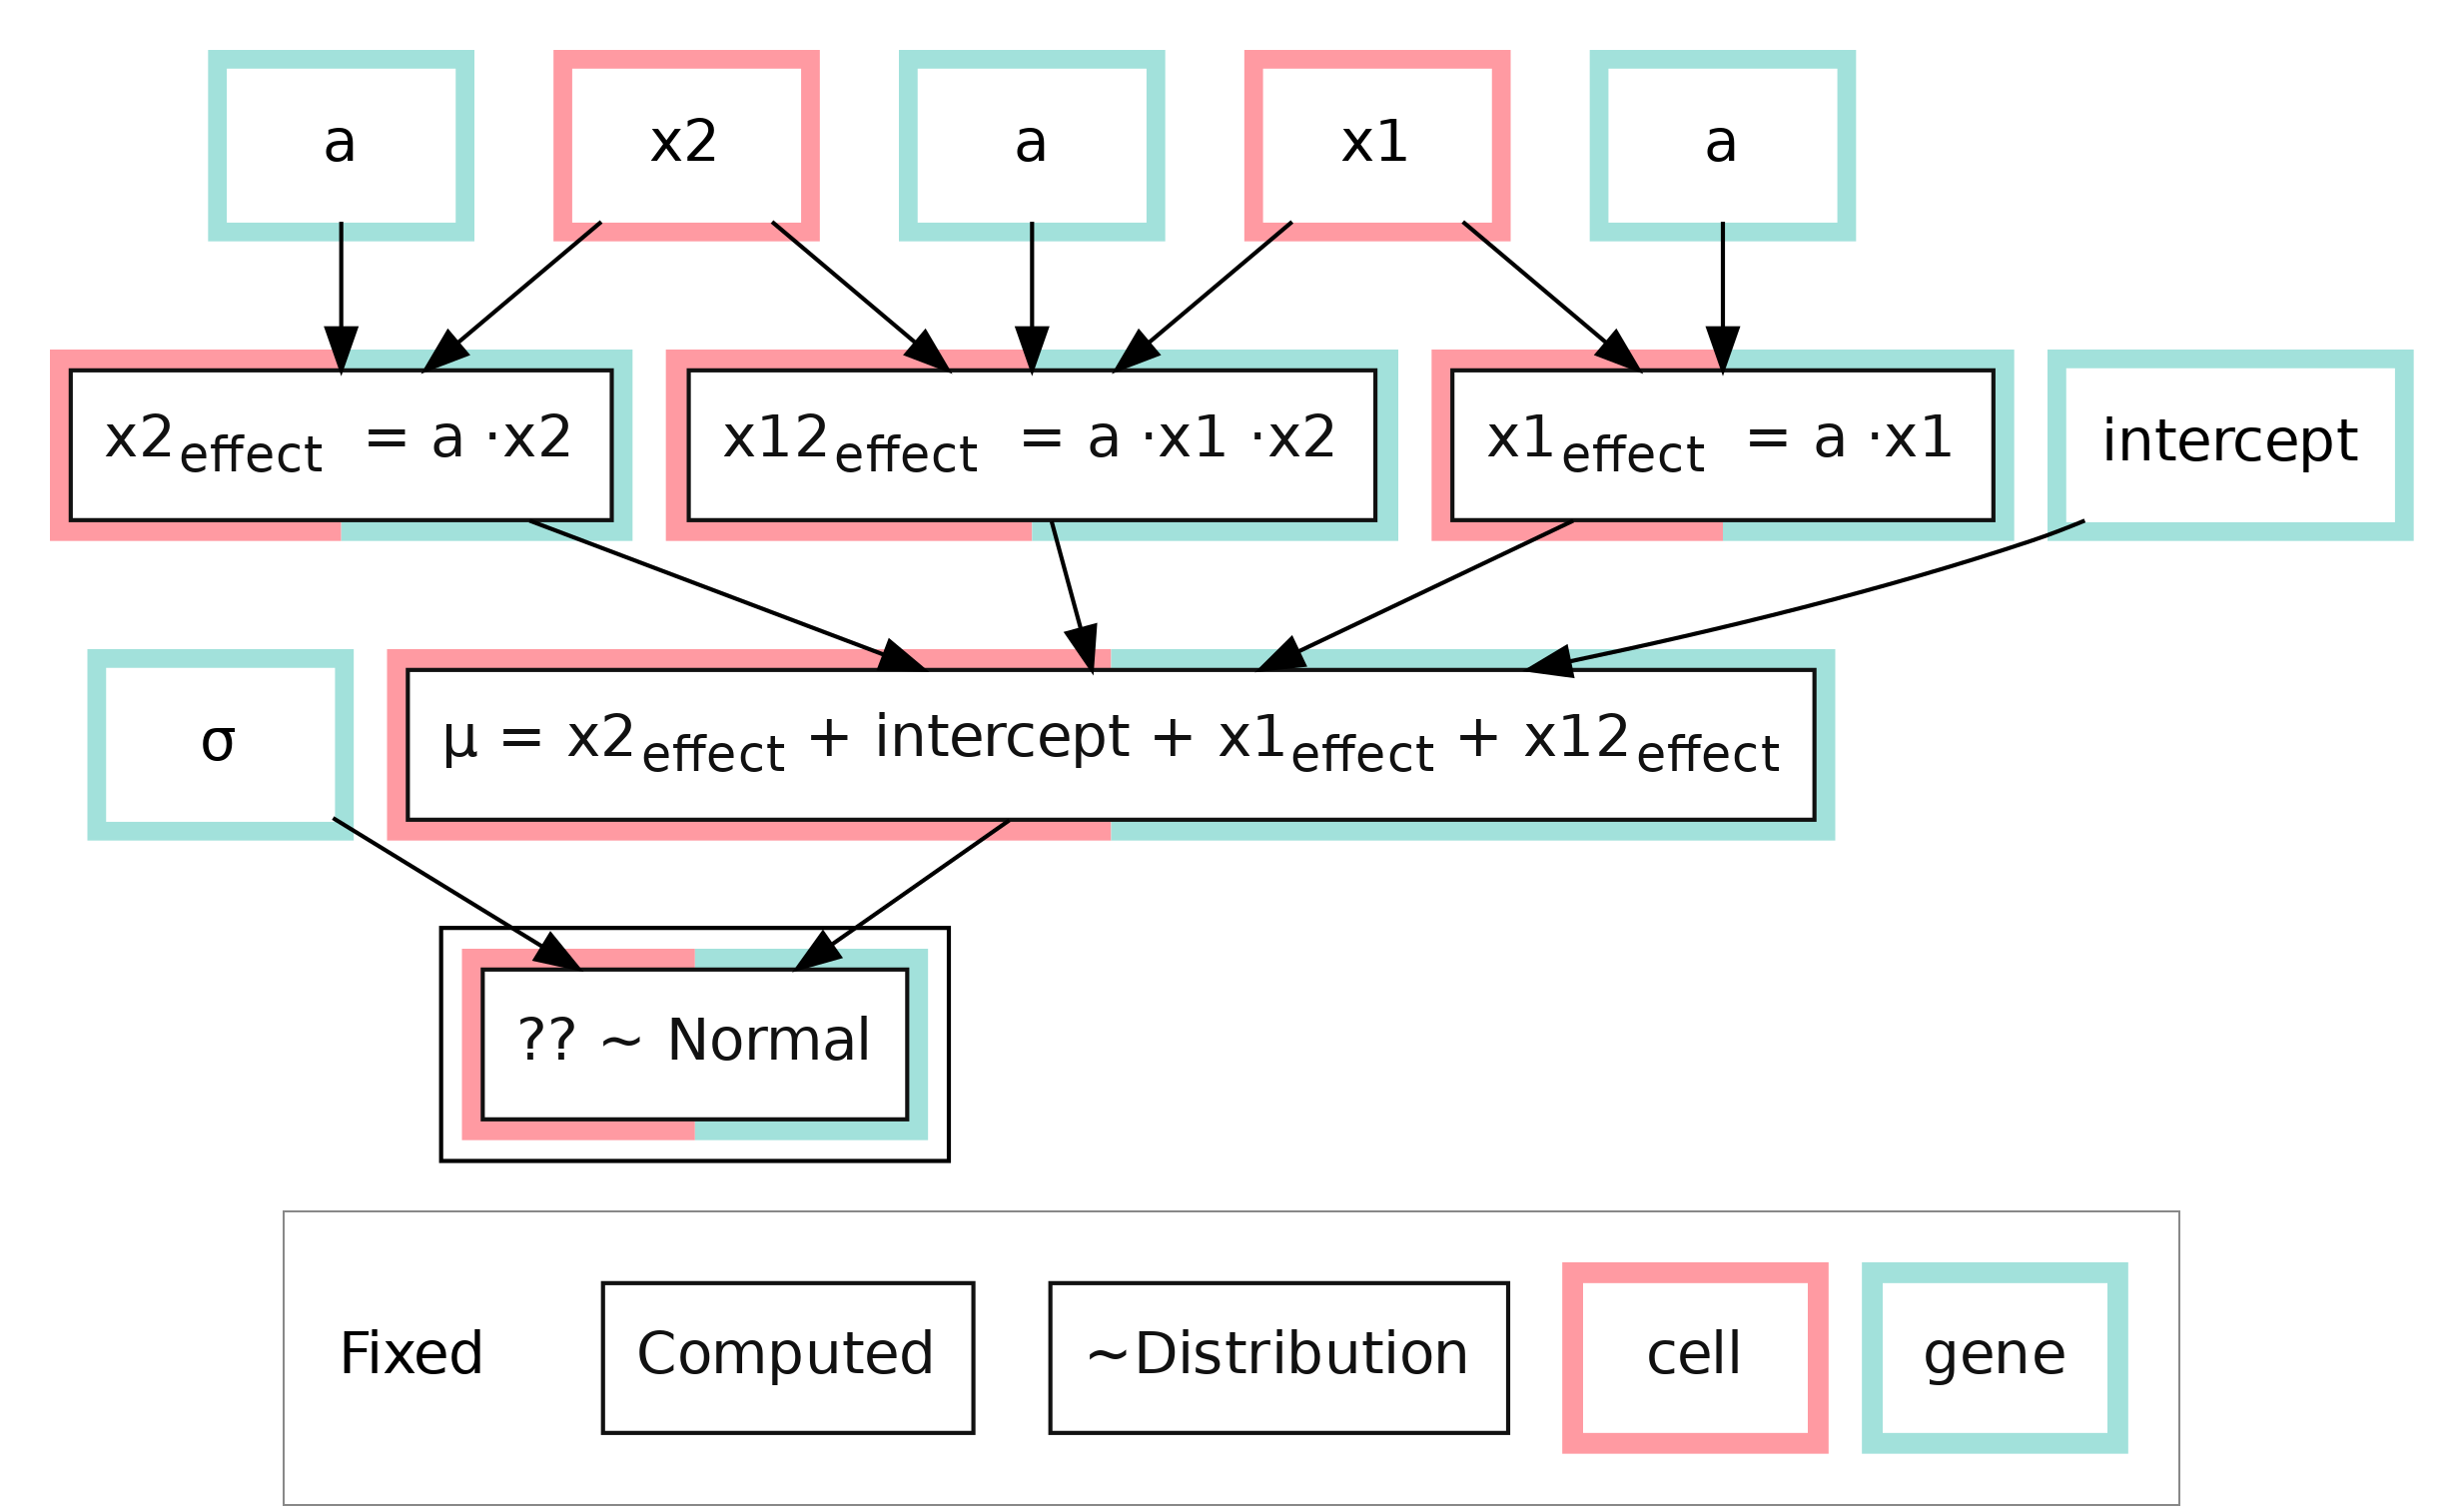

In [26]:
model_gs = la.Root(dist, label="ground truth", symbol="gs")
model_gs.plot()

In [27]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

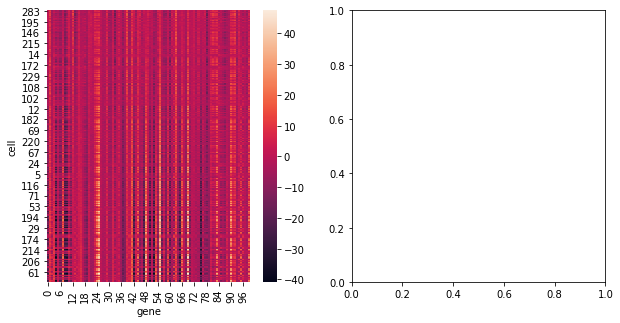

In [28]:
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x1").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)

## Linear regression with maximum likelihood

In [29]:
slope_x1 = la.Parameter(0.0, definition=la.Definition([genes]), label="slope_x1")
slope_x2 = la.Parameter(0.0, definition=la.Definition([genes]), label="slope_x2")
slope_x12 = la.Parameter(0.0, definition=la.Definition([genes]), label="slope_x12")
z = la.modular.Additive(
    intercept=intercept,
    x1_effect=la.links.scalar.Linear(x=x1, a=slope_x1),
    x2_effect=la.links.scalar.Linear(x=x2, a=slope_x2),
    x12_effect=la.links.scalars.Linear([x1, x2], a=slope_x12),
    definition=la.Definition([cells, genes]),
)

In [30]:
scale = la.Parameter(1.0, definition=scale, transforms=[la.transforms.Exp()])
dist = la.distributions.Normal(loc=z, scale=scale)

observation = la.Observation(observation_value, dist, label="observation")


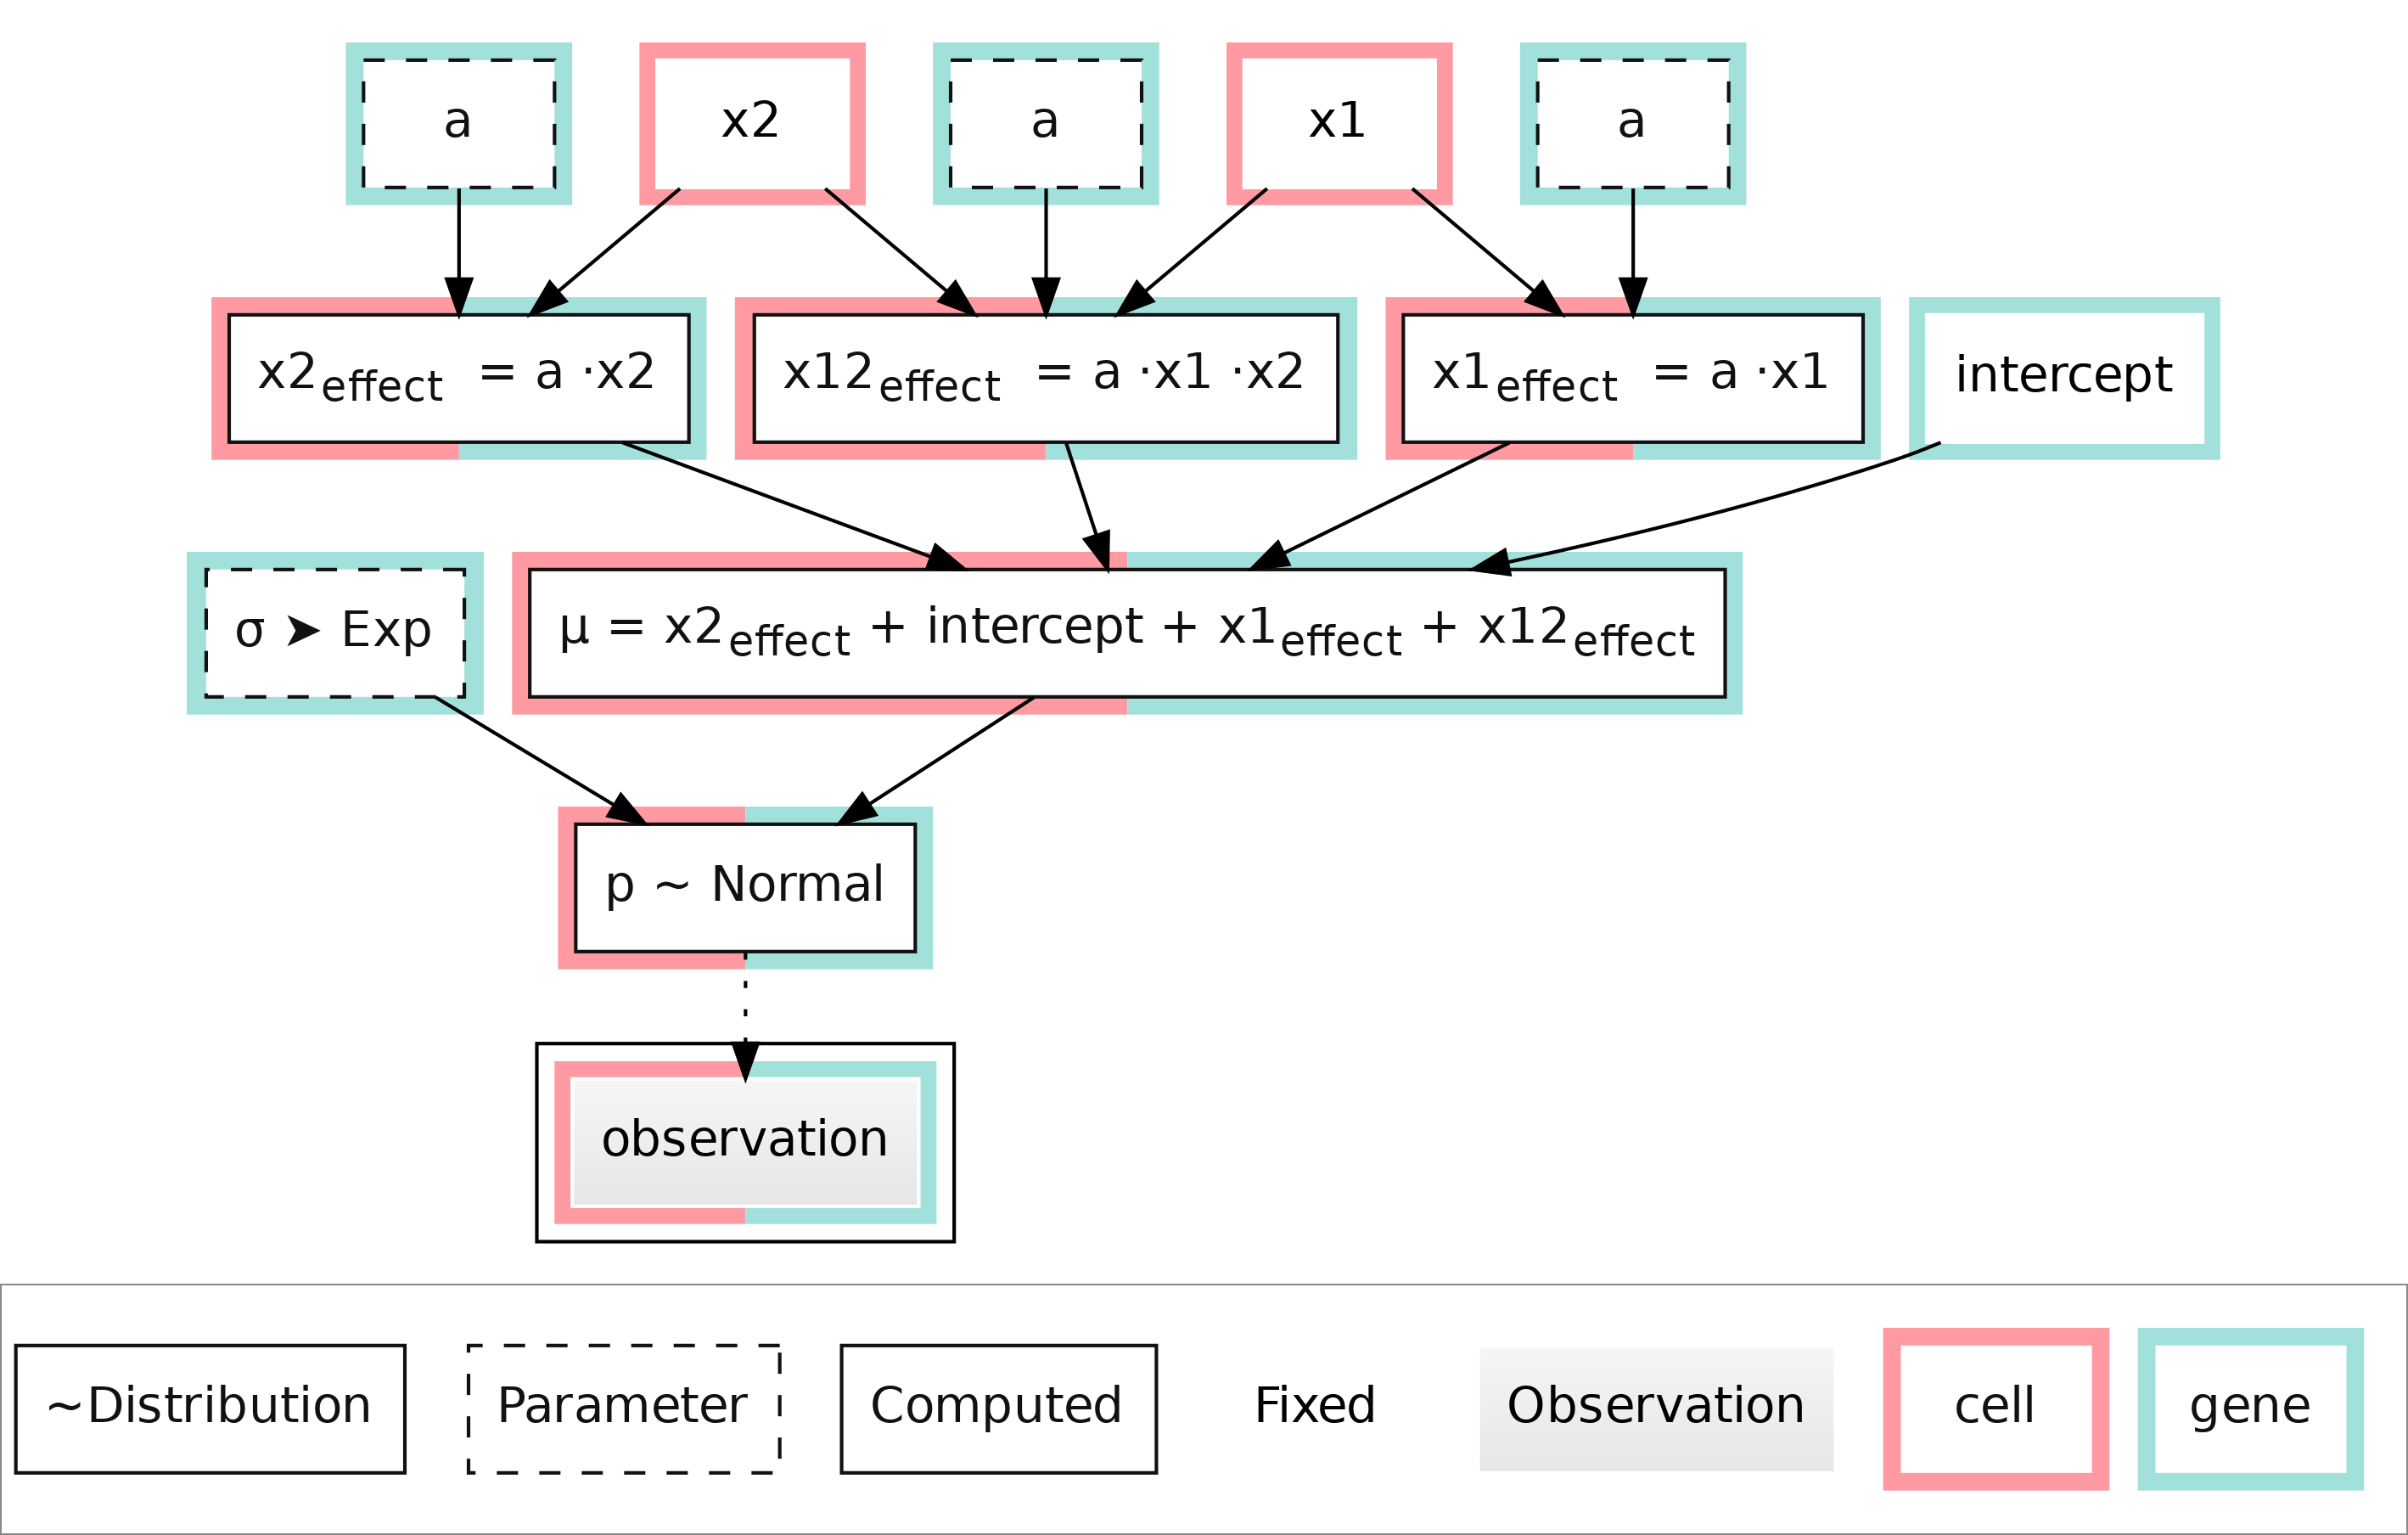

In [32]:
model = la.Root(observation, label="maximum likelihood", symbol="ml")
model.plot()

  0%|                                                                                                         …

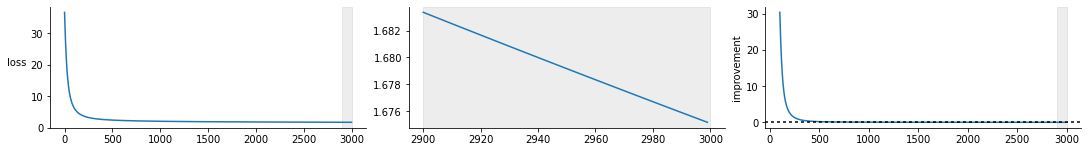

In [33]:
inference = la.infer.svi.SVI(
    model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)
trace.plot()

In [34]:
observed = la.posterior.Posterior(observation)
observed.sample(10, subsample_n=3)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

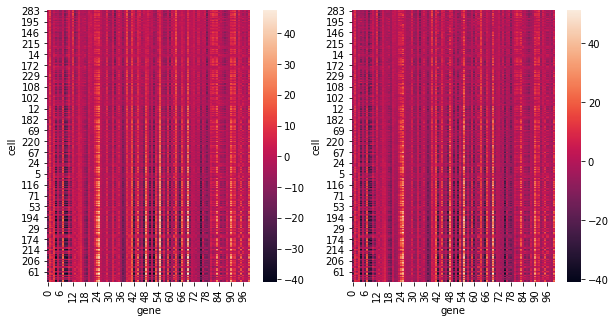

In [35]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x1").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)
modelled_value = observed.samples[observation.p].sel(sample=0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax=ax1)

In [36]:
parameter_ids = ["intercept", "slope_x1", "slope_x2", "slope_x12"]
parameter_values = []
for parameter_id in parameter_ids:
    parameter_values.append(
        pd.DataFrame(
            {
                "actual": model_gs.find(parameter_id).prior_pd(),
                "inferred": observed.samples[model.find(parameter_id)]
                .mean("sample")
                .to_pandas(),
                "parameter_id": parameter_id,
            }
        )
    )
parameter_values = pd.concat(parameter_values)

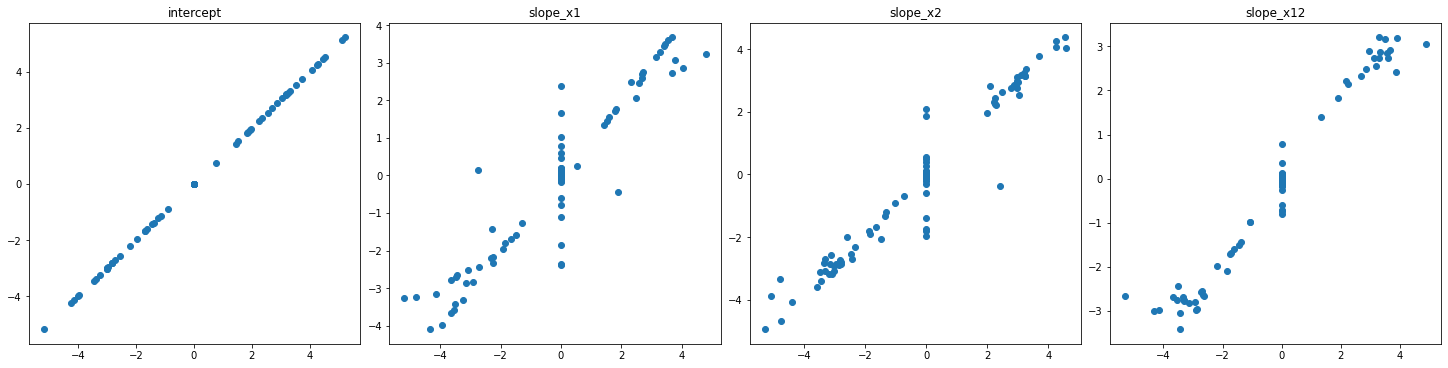

In [37]:
fig, axes = la.plotting.axes_wrap(len(parameter_ids))
for ax, parameter_id in zip(axes, parameter_ids):
    parameter_value = parameter_values.query("parameter_id == @parameter_id")
    ax.scatter(x=parameter_value["actual"], y=parameter_value["inferred"])
    ax.set_title(parameter_id)
    assert (
        np.corrcoef(parameter_value["actual"], parameter_value["inferred"])[0, 1] > 0.8
    ), paremter_id

## Linear regression with maximal likelihood and parameterized x

In [38]:
x1 = la.Parameter(0.5, definition=x1, transforms=[la.transforms.Logistic()], label="x1")

In [39]:
slope_x1 = la.Parameter(0.0, definition=la.Definition([genes]), label="slope_x1")
slope_x2 = la.Parameter(0.0, definition=la.Definition([genes]), label="slope_x2")
slope_x12 = la.Parameter(0.0, definition=la.Definition([genes]), label="slope_x12")
z = la.modular.Additive(
    intercept=intercept,
    x1_effect=la.links.scalar.Linear(x=x1, a=slope_x1),
    x2_effect=la.links.scalar.Linear(x=x2, a=slope_x2),
    x12_effect=la.links.scalars.Linear([x1, x2], a=slope_x12),
    definition=la.Definition([cells, genes]),
)

In [40]:
scale = la.Parameter(1.0, definition=scale, transforms=[la.transforms.Exp()])
dist = la.distributions.Normal(loc=z, scale=scale)

observation = la.Observation(observation_value, dist, label="observation")


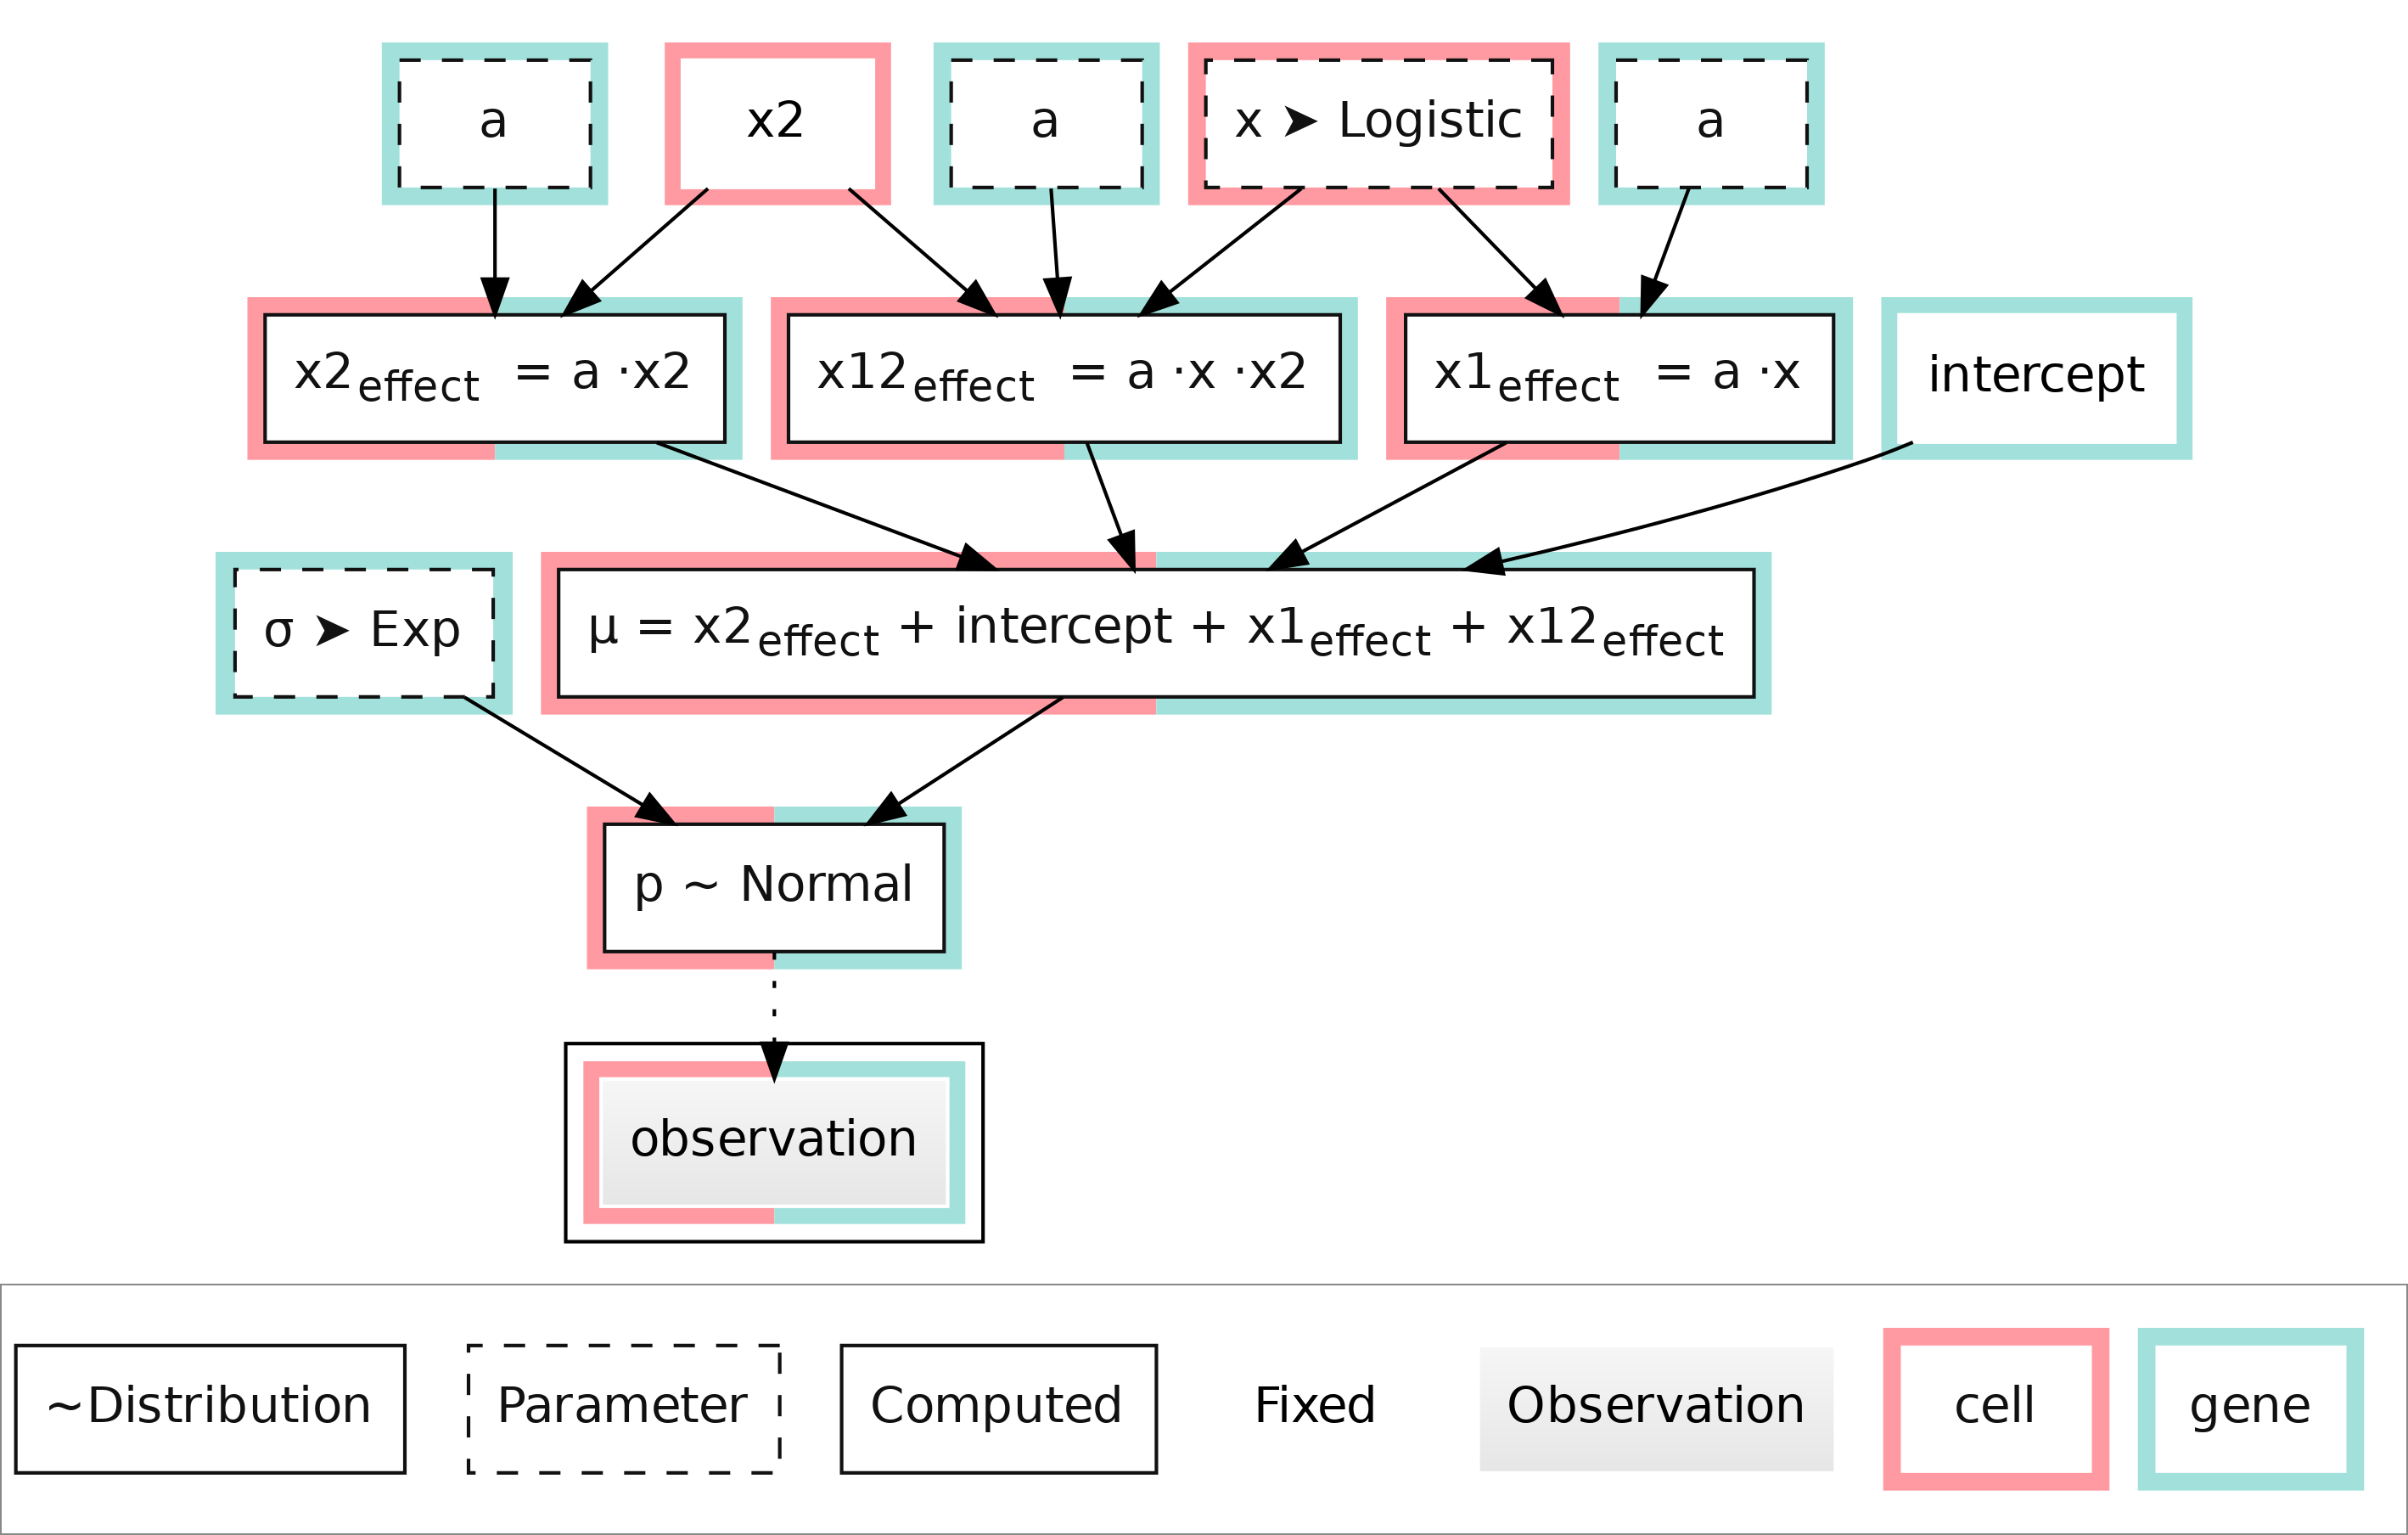

In [41]:
model = la.Root(observation)
model.plot()

  0%|                                                                                                         …

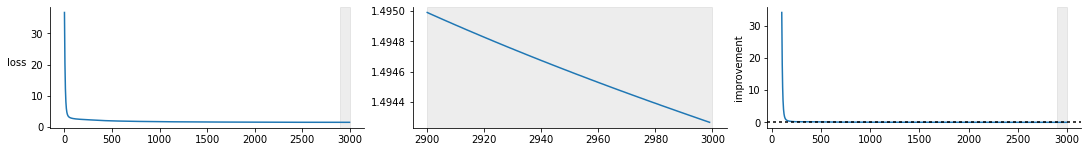

In [42]:
inference = la.infer.svi.SVI(
    model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)
trace.plot()

In [43]:
observed = la.posterior.Posterior(observation)
observed.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

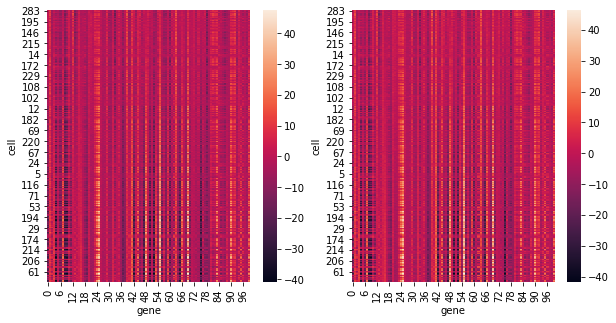

In [44]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x1").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)
modelled_value = observed.samples[observation.p].sel(sample=0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax=ax1)

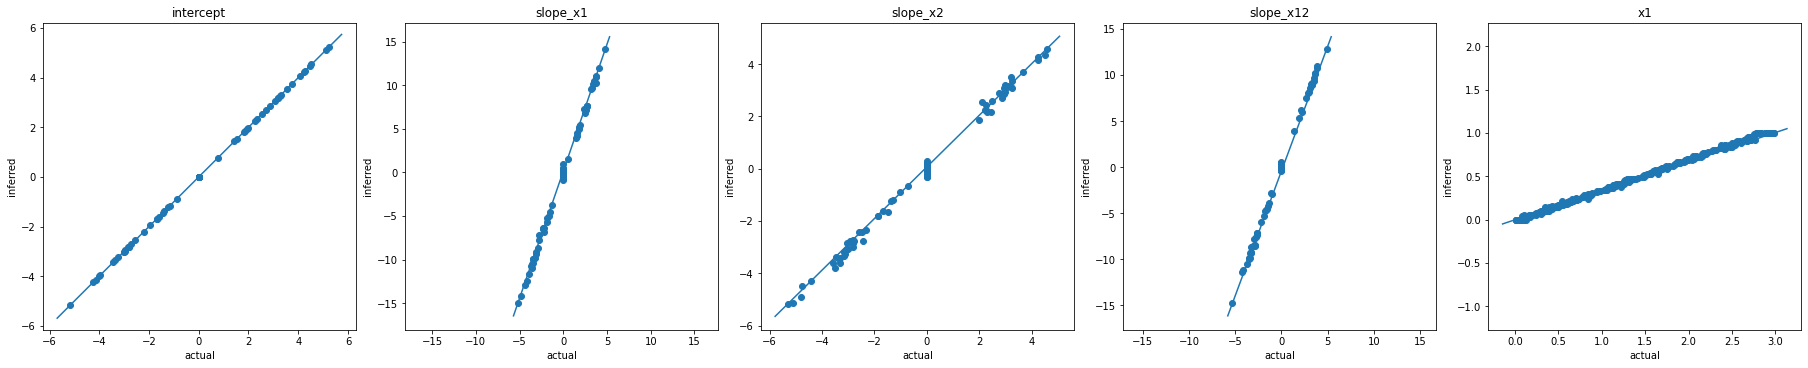

In [45]:
la.qa.cookbooks.check_parameters(
    la.qa.cookbooks.gather_parameters(
        ["intercept", "slope_x1", "slope_x2", "slope_x12", "x1"], model_gs, observed
    )
)

## Linear regression with variational inference and latent x

In [46]:
x1 = la.Latent(
    la.distributions.Uniform(0.0, 3.0),
    definition=la.Definition([cells]),
    label="x1",
    symbol="x1",
)

In [47]:
slope_x1_p = la.distributions.Normal(
    loc=0.0, scale=la.Parameter(1.0, transforms=[la.transforms.Exp()])
)
slope_x2_p = la.distributions.Normal(
    loc=0.0, scale=la.Parameter(1.0, transforms=[la.transforms.Exp()])
)
slope_x12_p = la.distributions.Normal(
    loc=0.0, scale=la.Parameter(1.0, transforms=[la.transforms.Exp()])
)

slope_x1 = la.Latent(slope_x1_p, definition=la.Definition([genes]), label="slope_x1")
slope_x2 = la.Latent(slope_x2_p, definition=la.Definition([genes]), label="slope_x2")
slope_x12 = la.Latent(slope_x12_p, definition=la.Definition([genes]), label="slope_x12")

z = la.modular.Additive(
    intercept=intercept,
    x1_effect=la.links.scalar.Linear(x=x1, a=slope_x1),
    x2_effect=la.links.scalar.Linear(x=x2, a=slope_x2),
    x12_effect=la.links.scalars.Linear([x1, x2], a=slope_x12),
    definition=la.Definition([cells, genes]),
)

In [48]:
scale = la.Parameter(1.0, definition=scale, transforms=[la.transforms.Exp()])
dist = la.distributions.Normal(loc=z, scale=scale)

observation = la.Observation(observation_value, dist, label="observation")


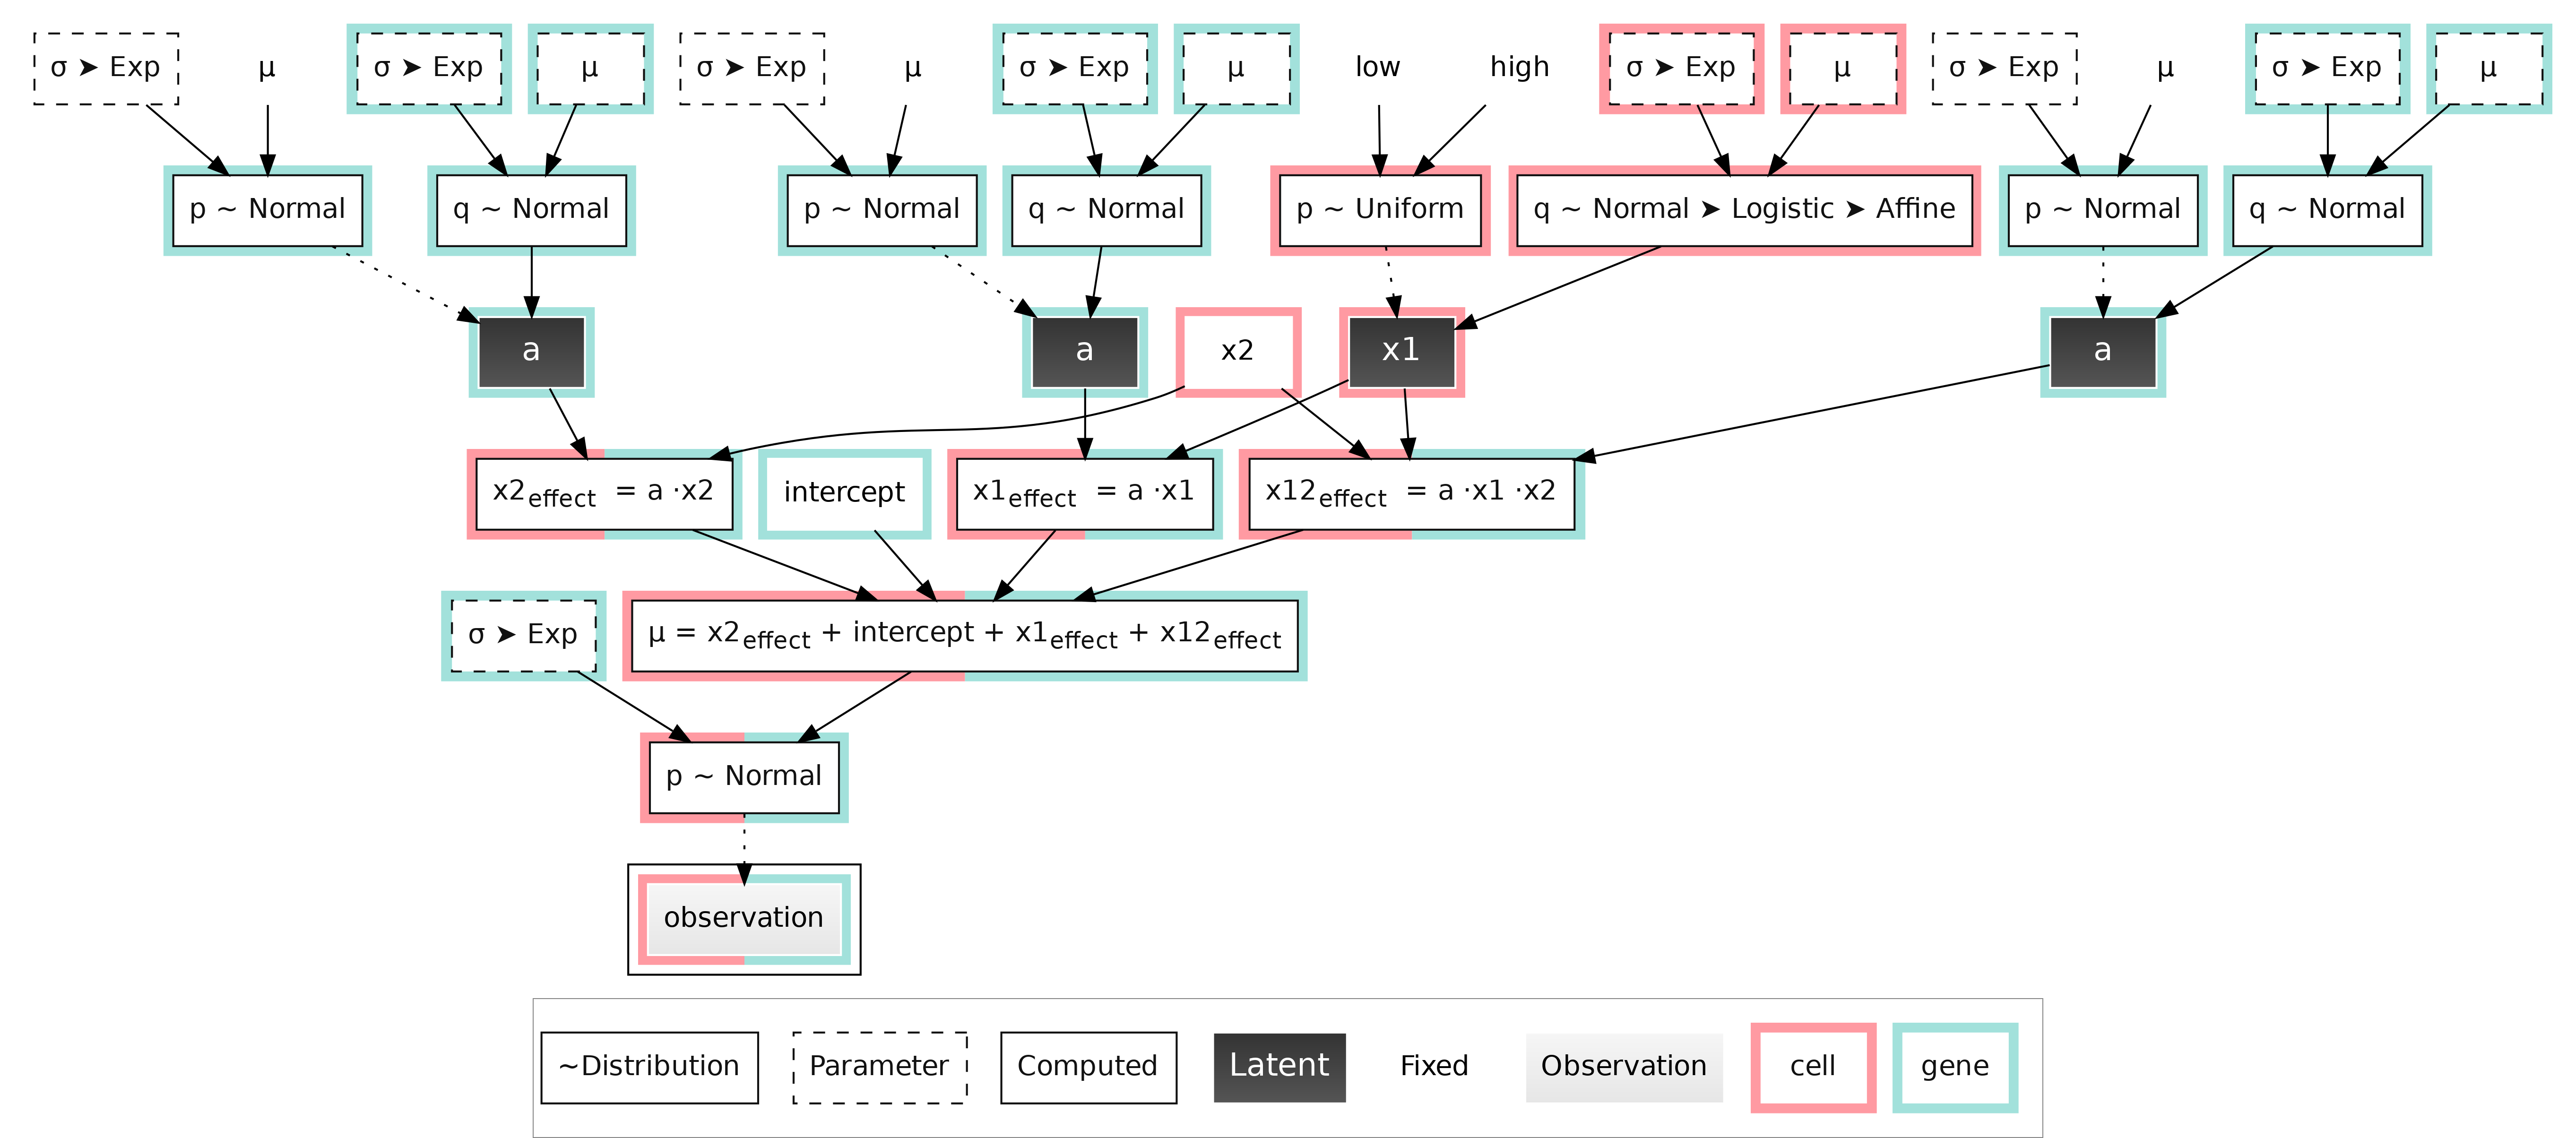

In [49]:
model = la.Root(observation)
model.plot()

  0%|                                                                                                         …

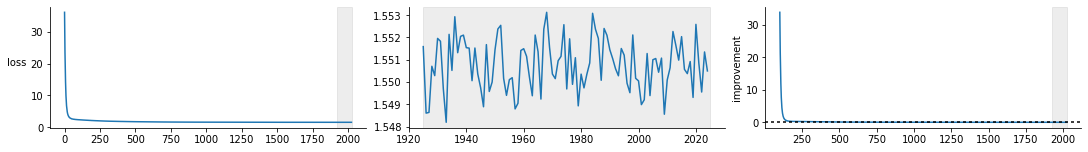

In [50]:
inference = la.infer.svi.SVI(
    model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(5000)
trace.plot()

In [51]:
observed = la.posterior.vector.VectorObserved(observation)
observed.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

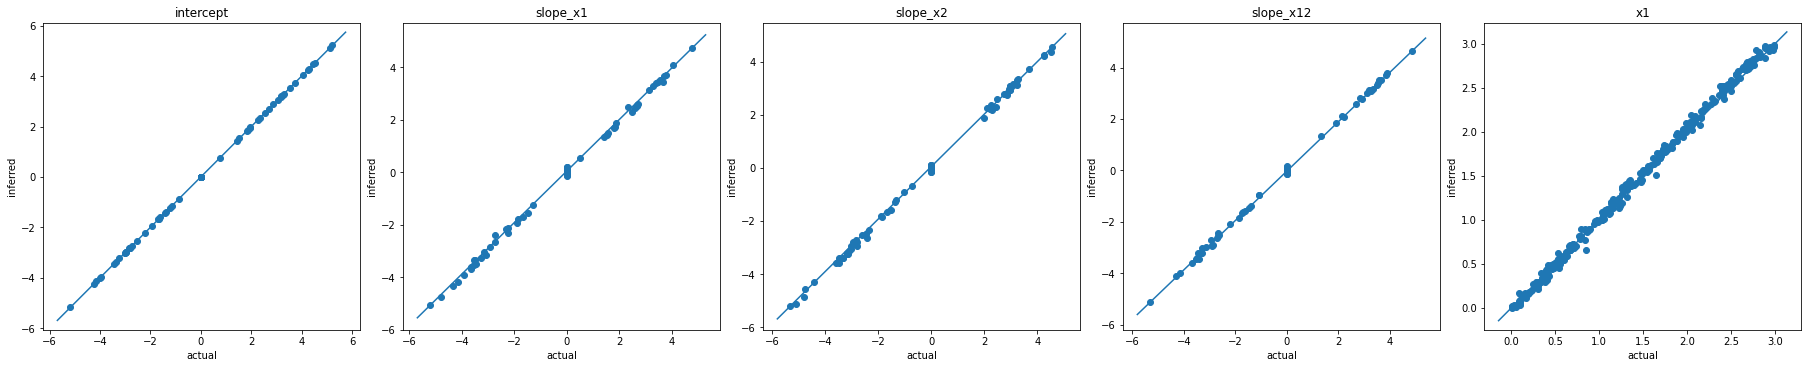

In [52]:
la.qa.cookbooks.check_parameters(
    la.qa.cookbooks.gather_parameters(
        ["intercept", "slope_x1", "slope_x2", "slope_x12", "x1"], model_gs, observed
    )
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

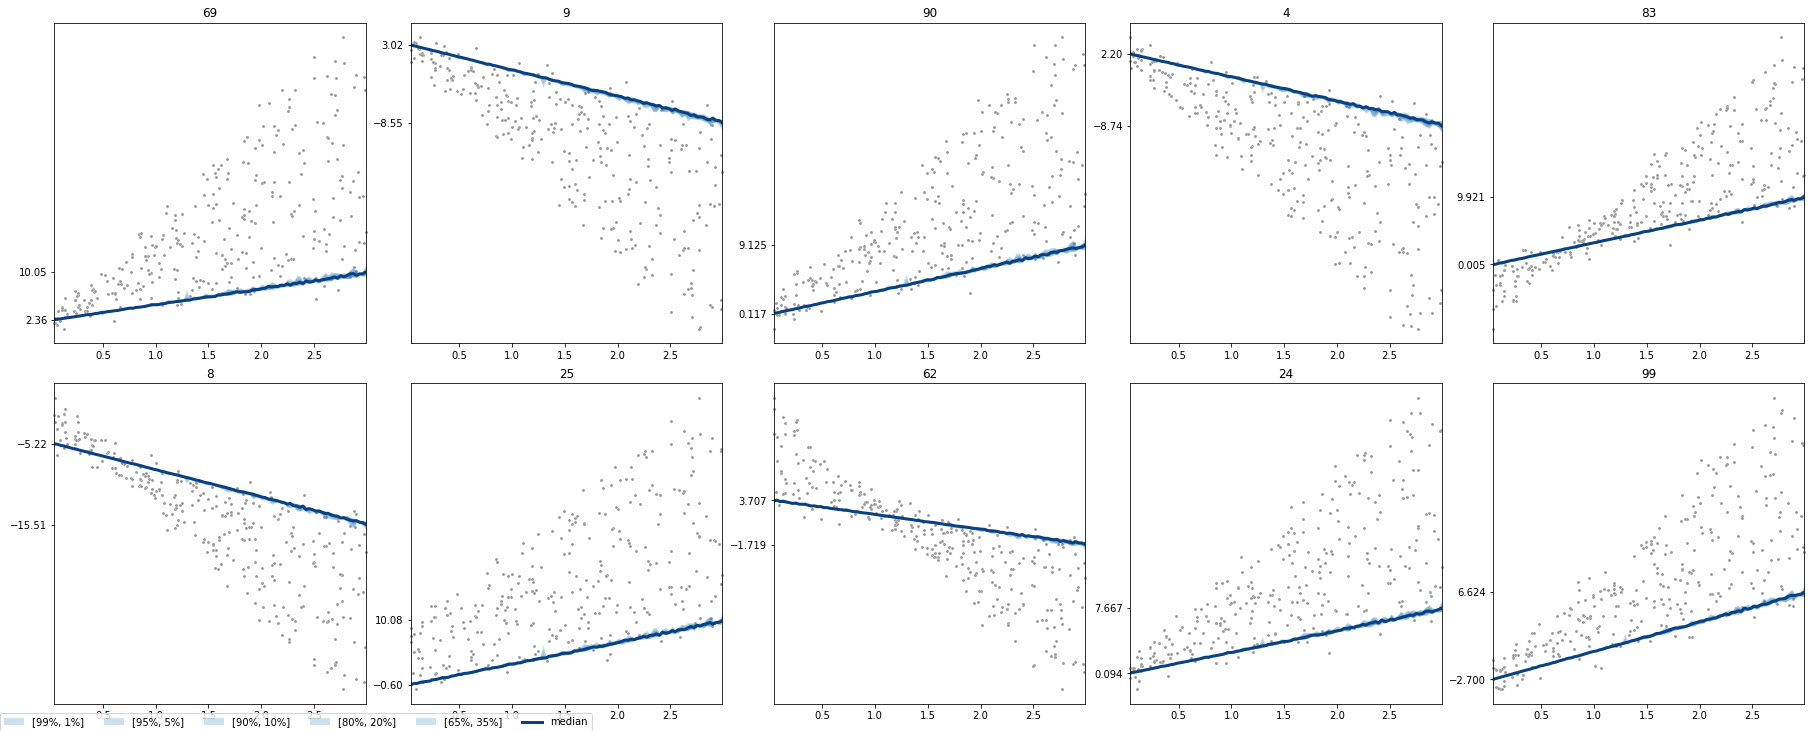

In [53]:
z.empirical = xr.DataArray(observation_value)
causal_x2 = la.posterior.scalar.ScalarVectorCausal(x2, observation, observed=observed)
causal_x2.sample(10)
causal_x2.sample_random(10)
causal_x2.plot_features()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

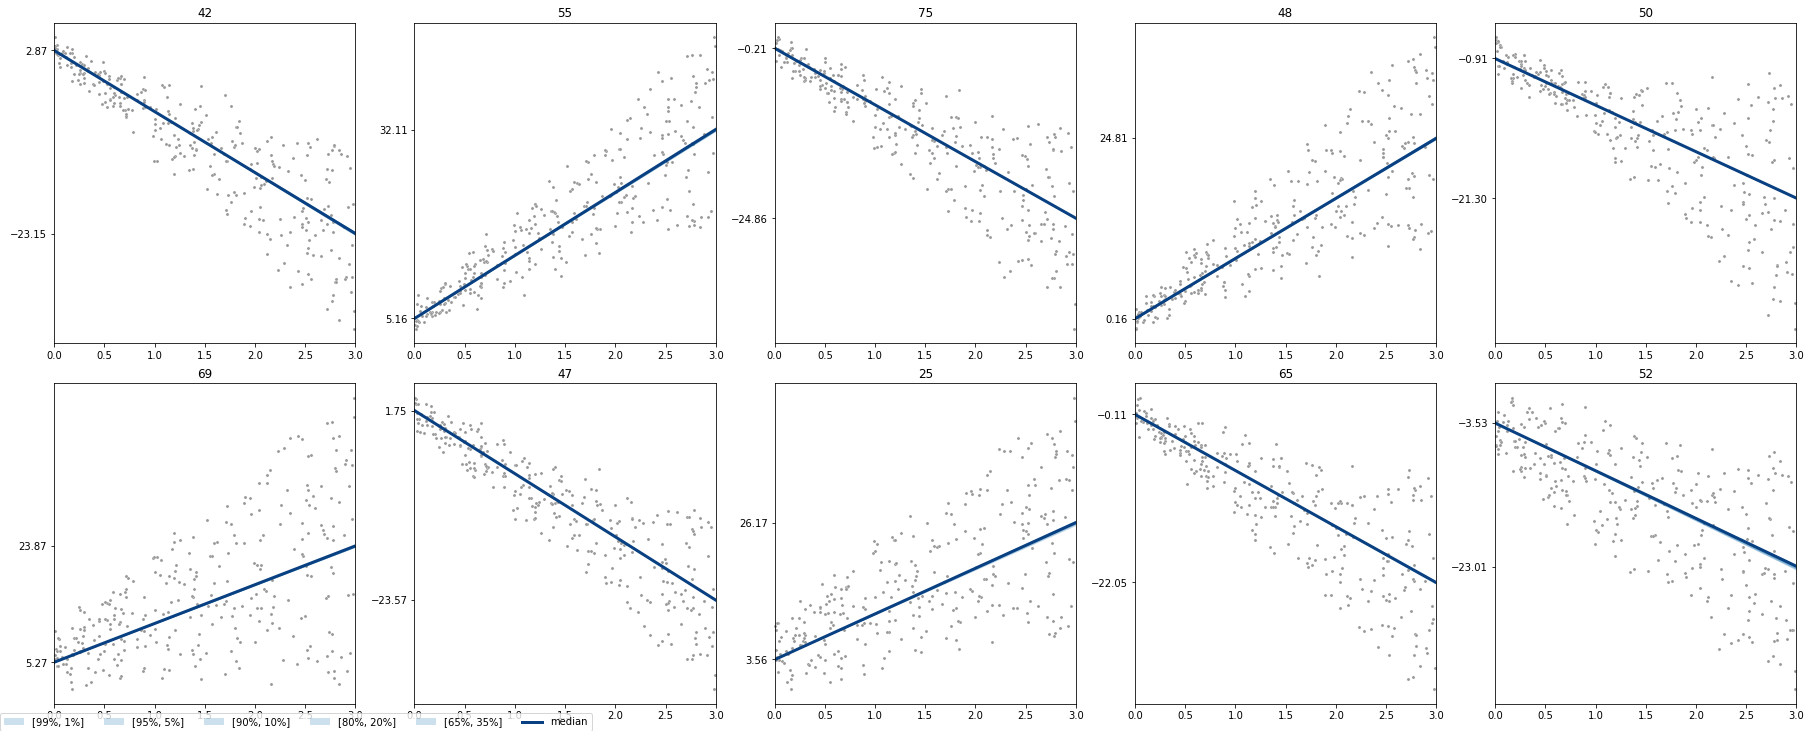

In [54]:
causal_x1 = la.posterior.scalar.ScalarVectorCausal(x1, observation, observed=observed)
causal_x1.sample(10)
causal_x1.sample_random(10)
causal_x1.plot_features()

  0%|          | 0/10 [00:00<?, ?it/s]

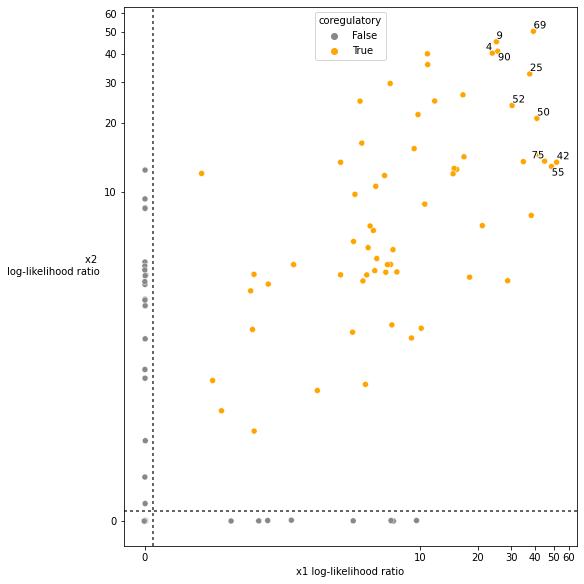

In [55]:
causal_x1_x2 = la.posterior.scalarscalar.ScalarScalarVectorCausal(causal_x1, causal_x2)
causal_x1_x2.sample(10)
causal_x1_x2.plot_likelihood_ratio()

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='lr_x2'>

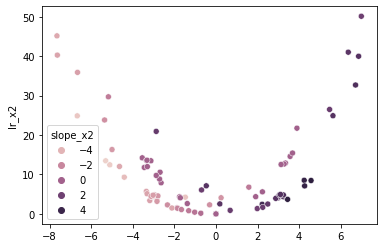

In [56]:
sns.scatterplot(
    gene_info["slope_x12"] + gene_info["slope_x2"],
    causal_x1_x2.scores["lr_x2"],
    hue=gene_info["slope_x2"],
)

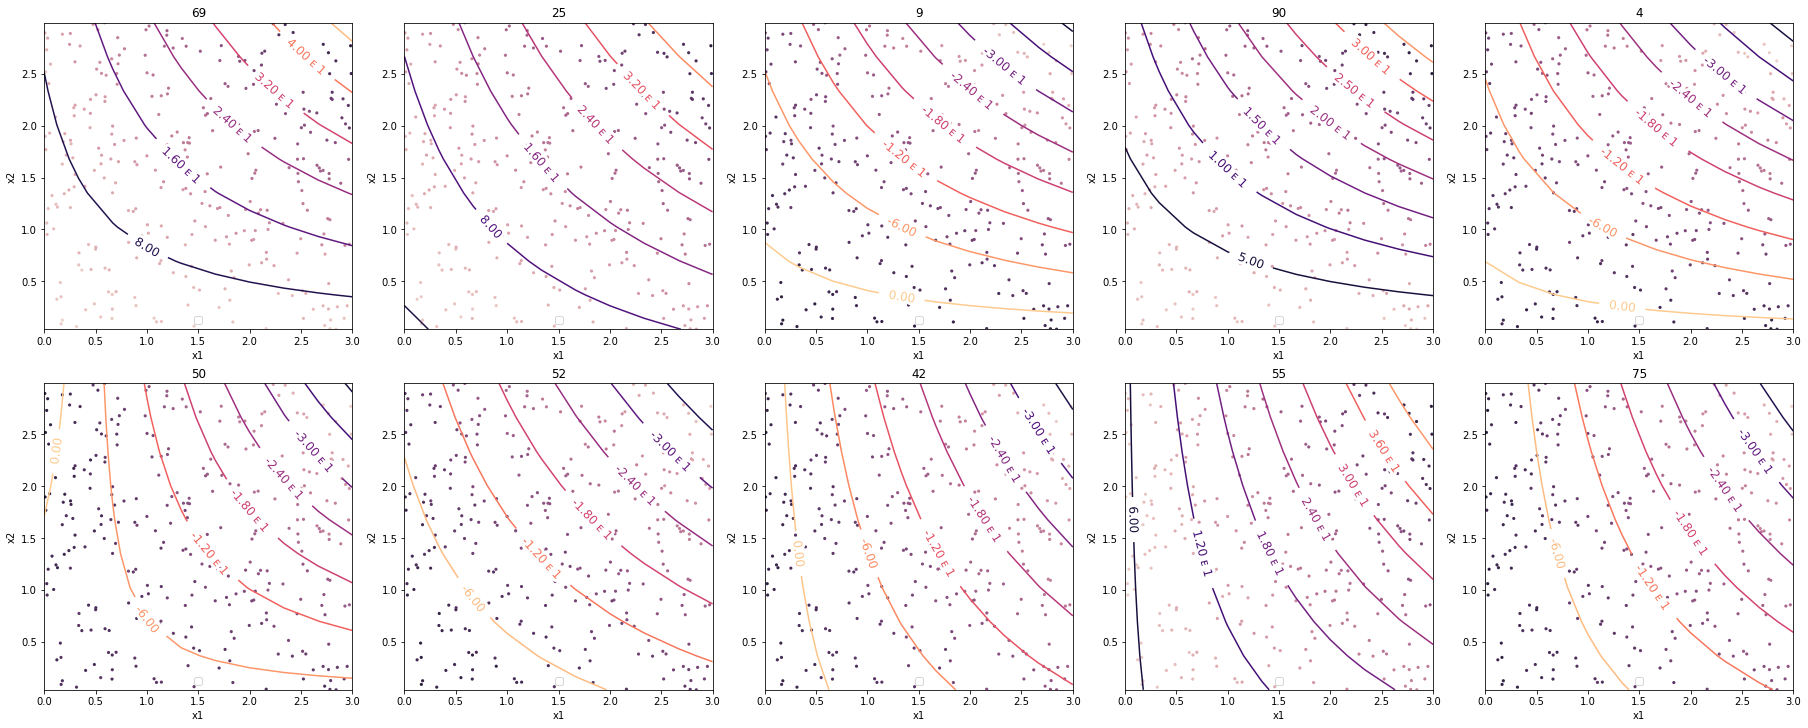

In [57]:
causal_x1_x2.plot_features_contour()

<AxesSubplot:xlabel='gene', ylabel='cell'>

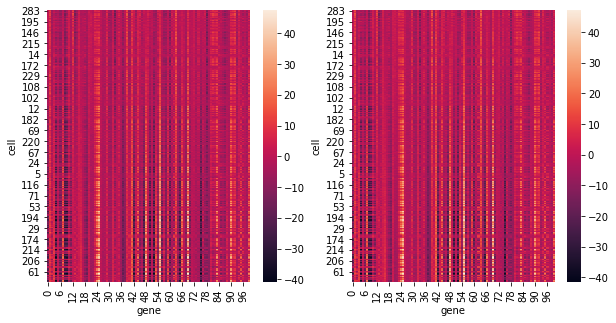

In [58]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x1").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)
modelled_value = observed.samples[observation.p].sel(sample=0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax=ax1)